In [1]:
#| default_exp lp_diffusion
from diffusion_curvature.gaussian_invariance import compute_anisotropic_diffusion_matrix_from_graph
from diffusion_curvature.core import gaussian_kernel, plot_3d, diffusion_matrix
from nbdev.showdoc import *
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import diffusion_curvature
# Reload any changes made to external files
%load_ext autoreload
%autoreload 2

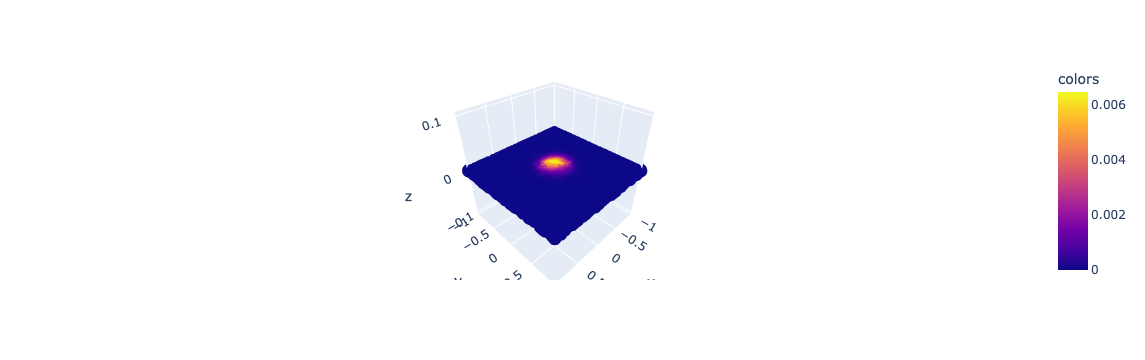

In [2]:
coords_2d = np.random.rand(5000,2)*2-1
coords_2d = np.vstack([np.zeros(2),np.array([0,0.2]),np.array([0,-0.2]),np.zeros(2),coords_2d])
A = gaussian_kernel(coords_2d, kernel_type="adaptive",k=10)
P = compute_anisotropic_diffusion_matrix_from_graph(A, alpha=1)
t = 8
P_t = np.linalg.matrix_power(P,t)
y = P_t[0]
# plot, now in 3d
def plot_diffusion_as_3d(points,signal):
    combined_points = np.hstack([points,signal[:,None]])
    plot_3d(combined_points,signal,lim=1,zlim=max(signal)+0.1, use_plotly=True)
plot_diffusion_as_3d(coords_2d,y)

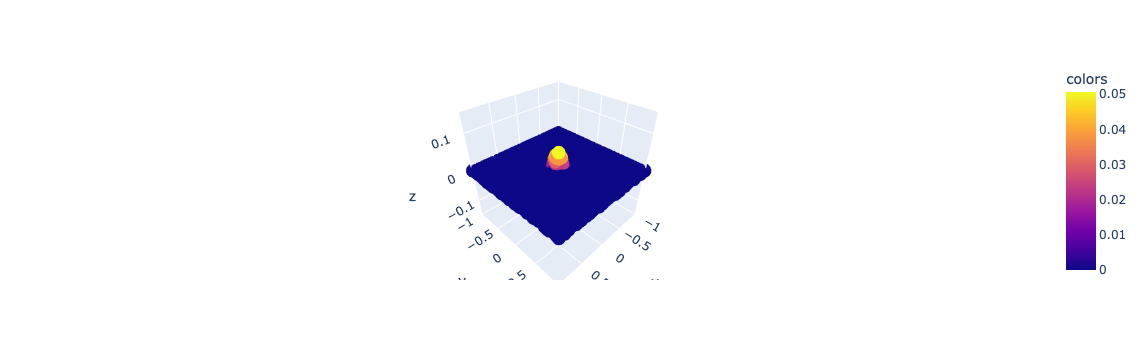

In [3]:
y_reversed = y**(t)
y_reversed = y_reversed/np.sum(y_reversed) # normalize
plot_diffusion_as_3d(coords_2d,y_reversed)

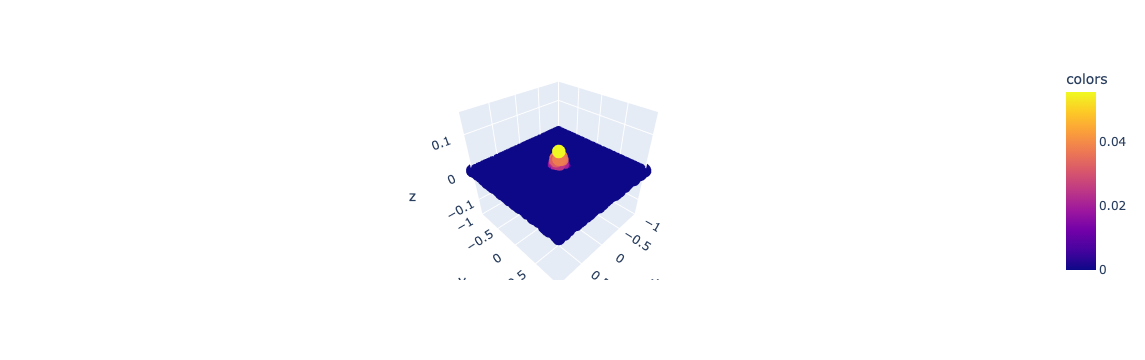

In [4]:
plot_diffusion_as_3d(coords_2d,P[0])

In [5]:
np.linalg.norm(y_reversed - P[0])

0.051115201388638266

In [6]:
np.linalg.norm(y_reversed - P[0])

0.051115201388638266

In [7]:
def fit_kernel_bandwidth_adaptive(query_distribution, pointcloud, center_idx):
    # finds the kernel bandwidth that best fits the query distribution
    # currently brute forcing by testing a bunch of possible ks
    ks = list(range(2,20))
    fits = []
    for k in ks:
        P = gaussian_kernel(pointcloud,kernel_type="adaptive",k=k)
        candidate_signal = P[center_idx]
        fits.append(np.linalg.norm(candidate_signal - query_distribution))
    return np.argmin(fits)+2
def fit_kernel_bandwidth_fixed(query_distribution, pointcloud, center_idx):
    # finds the kernel bandwidth that best fits the query distribution
    # currently brute forcing by testing a bunch of possible ks
    sigmas = np.arange(0.02,0.3,0.01)
    fits = []
    for s in sigmas:
        P = gaussian_kernel(pointcloud,kernel_type="fixed",sigma=s)
        candidate_signal = P[center_idx]
        fits.append(np.linalg.norm(candidate_signal - query_distribution))
    return np.argmin(fits)+2

In [8]:
fit_kernel_bandwidth_adaptive(y_reversed,coords_2d,0)

12

# Applying to the Sphere

In [9]:
from diffusion_curvature.datasets import sphere
X, ks_real = sphere(2000)
A = gaussian_kernel(X, kernel_type="adaptive",k=10)
P = compute_anisotropic_diffusion_matrix_from_graph(A, alpha=1)
t = 8
P_t = np.linalg.matrix_power(P,t)
y = P_t[0]
y_reversed = y**(t)

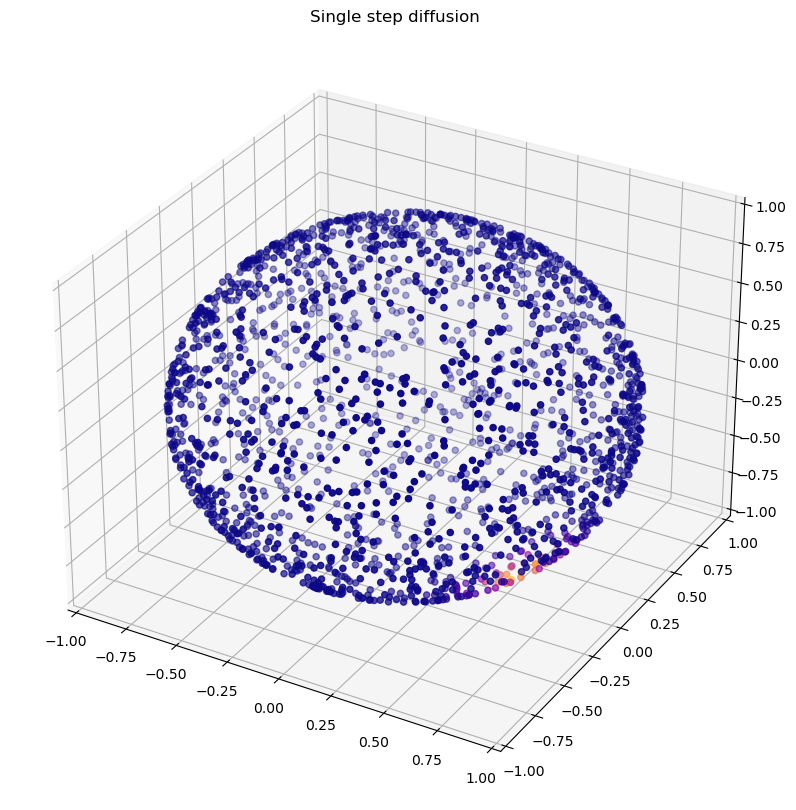

In [10]:
plot_3d(X,P[0],title="Single step diffusion")

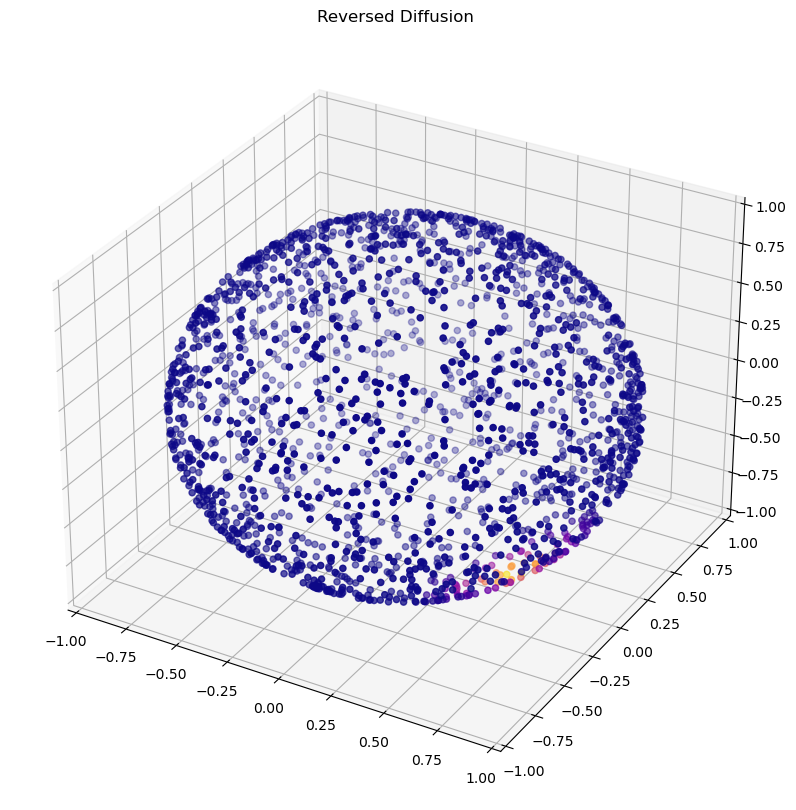

In [11]:
plot_3d(X,distribution=y_reversed,title="Reversed Diffusion")

In [12]:
fit_kernel_bandwidth_adaptive(y_reversed,X,0)

19

# Tying it all together into a method

In [13]:
def reverse_diffusion_curvature(X,t=8, k = 10):
    A = gaussian_kernel(X, kernel_type="adaptive",k=k)
    P = compute_anisotropic_diffusion_matrix_from_graph(A, alpha=1)
    # get powered diffusions
    Pt = np.linalg.matrix_power(P,t)
    # calculate reversed diffusions and normalize
    P_reversed = Pt**t
    P_reversed = P_reversed / np.sum(P_reversed,axis=1)[:,None]
    # laboriously fit kernel bandwidth to each curvature
    ks = np.empty(len(X))
    for i in trange(len(X)):
        ks[i] = k - fit_kernel_bandwidth_adaptive(P_reversed[i],X,i)
    return ks

In [14]:
from diffusion_curvature.datasets import torus
X,ks_real = torus(2000)

In [15]:
ks = reverse_diffusion_curvature(X,t=8)

  0%|          | 0/1023 [00:00<?, ?it/s]

KeyboardInterrupt: 

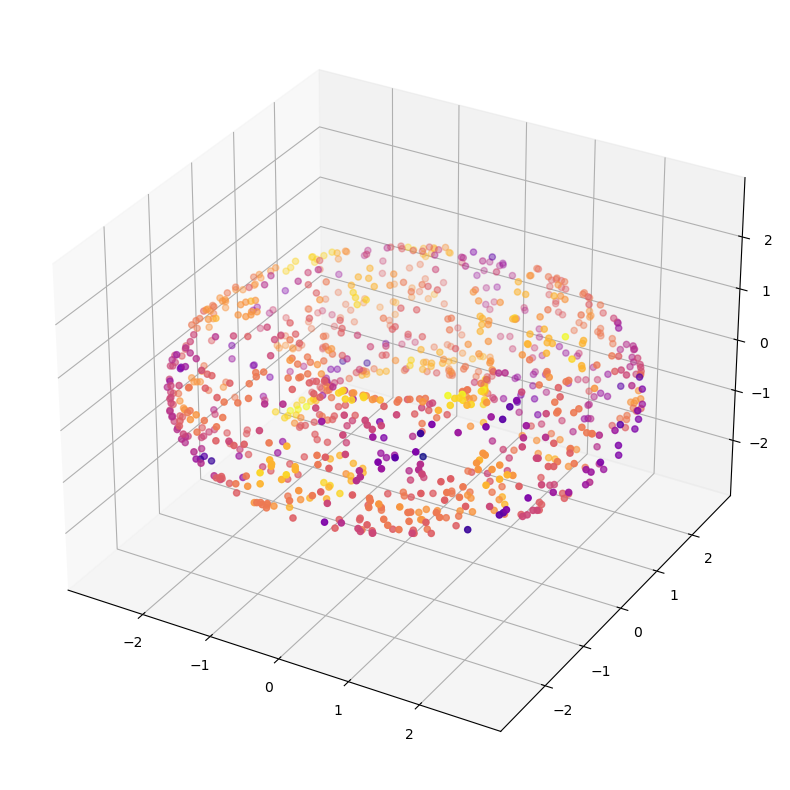

In [ ]:
plot_3d(X,ks)

In [ ]:
A = gaussian_kernel(X, kernel_type="adaptive",k=10)
P = compute_anisotropic_diffusion_matrix_from_graph(A, alpha=1)
ks_denoised = P@ks

In [ ]:
min(ks)

-9.0

In [ ]:
max(ks)

3.0

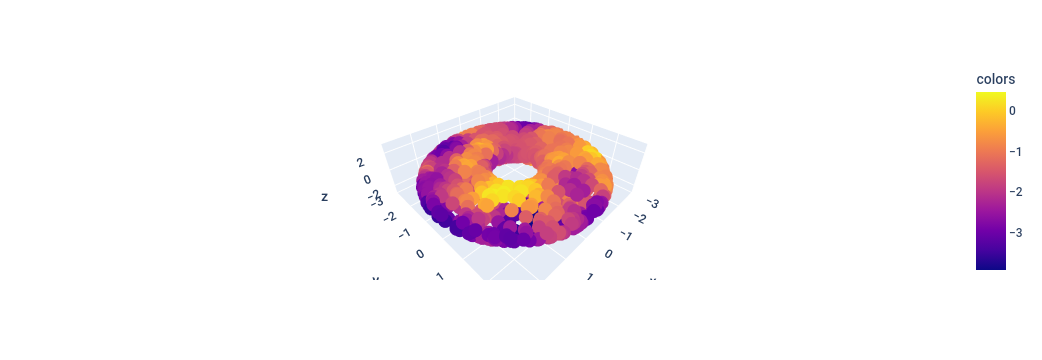

In [ ]:
plot_3d(X,ks_denoised, use_plotly=True)

In [22]:
import scipy.stats
def reverse_diffusion_curvature_l2_concentration(X,t=8, k = 10):
    A = gaussian_kernel(X, kernel_type="adaptive",k=k)
    P = compute_anisotropic_diffusion_matrix_from_graph(A, alpha=1)
    # get powered diffusions
    Pt = np.linalg.matrix_power(P,t)
    # calculate reversed diffusions
    P_reversed = Pt**t
    P_reversed = P_reversed / np.sum(P_reversed,axis=1)[:,None]
    # take entropy of both as measure of concentration
    P_entropy = np.array([scipy.stats.entropy(x) for x in P])
    P_reversed_entropy = np.array([scipy.stats.entropy(x) for x in P_reversed])
    # take differences; we expect positive curvature to have a higher concentration -> higher l2 norm
    ks = P_reversed_entropy #- P_entropy
    return ks

In [16]:
from diffusion_curvature.datasets import torus
X,ks_real = torus(5000)

In [23]:
ks = reverse_diffusion_curvature_l2_concentration(X,t=16, k = 20)

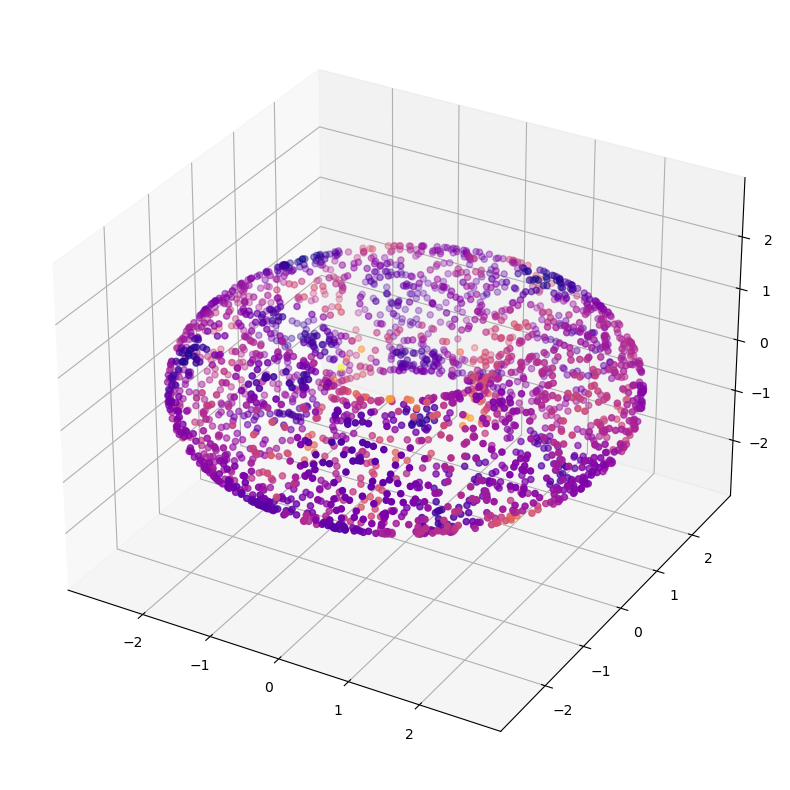

In [24]:
plot_3d(X,ks)

In [25]:
def entropy_of_diffusion(X,t=8,k=10):
    A = gaussian_kernel(X, kernel_type="adaptive",k=k)
    P = compute_anisotropic_diffusion_matrix_from_graph(A, alpha=1)
    # get powered diffusions
    Pt = np.linalg.matrix_power(P,t)
    P_entropy = np.array([scipy.stats.entropy(x) for x in Pt])
    return P_entropy

In [26]:
ks = entropy_of_diffusion(X)

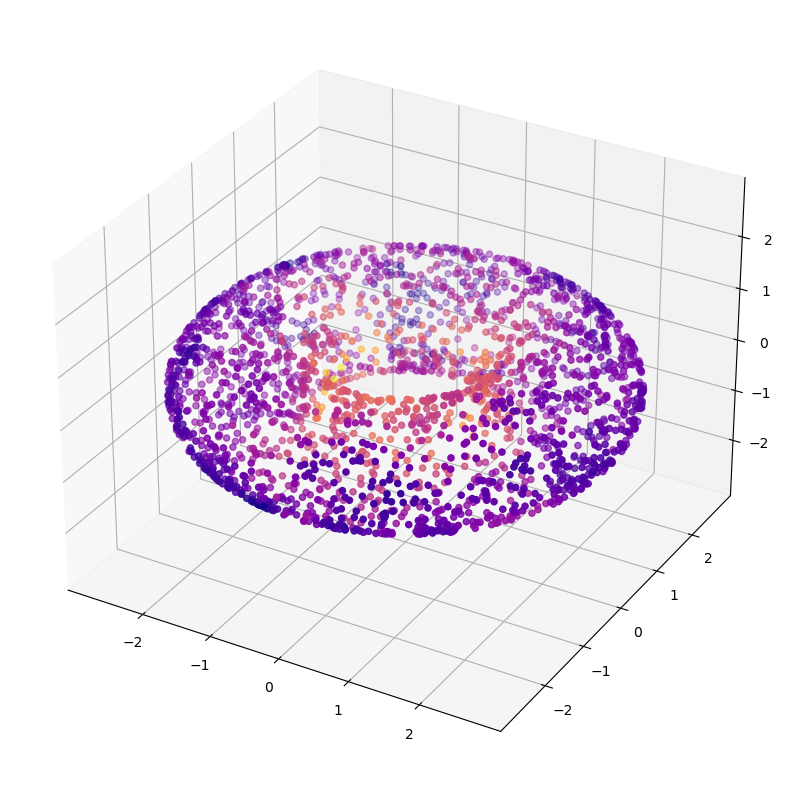

In [27]:
plot_3d(X,ks)

# Entropy Ablations

In [28]:
A = gaussian_kernel(X, kernel_type="adaptive",k=10)
P = compute_anisotropic_diffusion_matrix_from_graph(A, alpha=1)
# get powered diffusions
Pt = np.linalg.matrix_power(P,8)
P_entropy = np.array([scipy.stats.entropy(x) for x in Pt])

In [29]:
P_local_entropy = np.array([scipy.stats.entropy(x) for x in P])

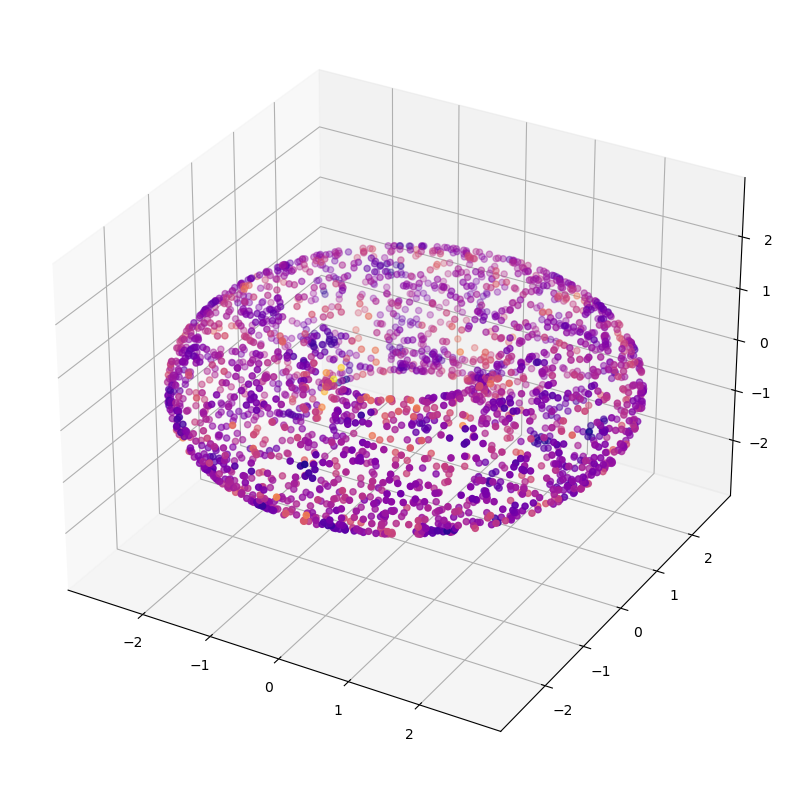

In [30]:
plot_3d(X,P_local_entropy)

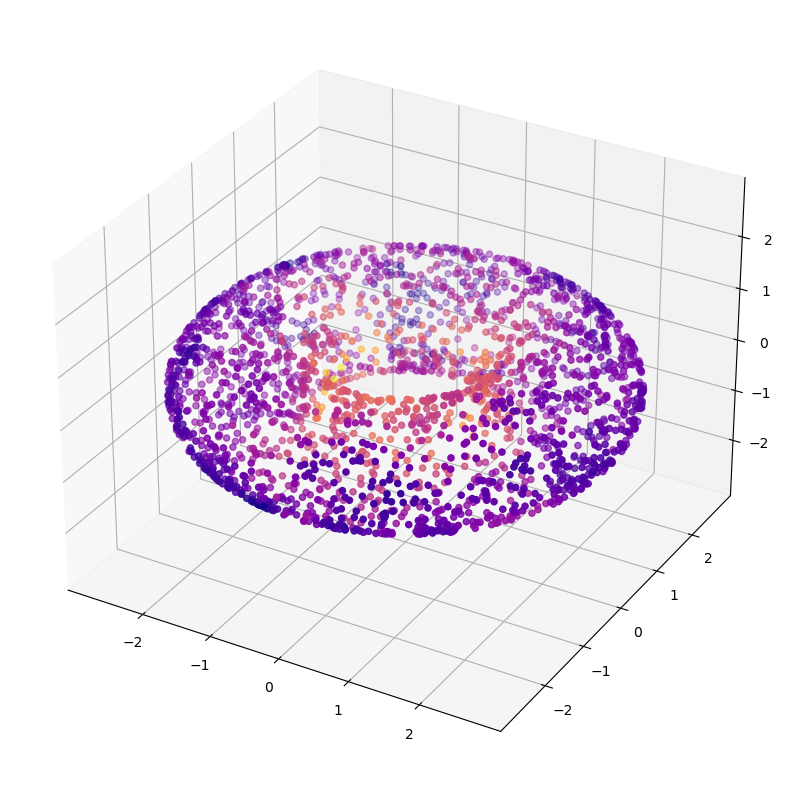

In [31]:
plot_3d(X,P_entropy)

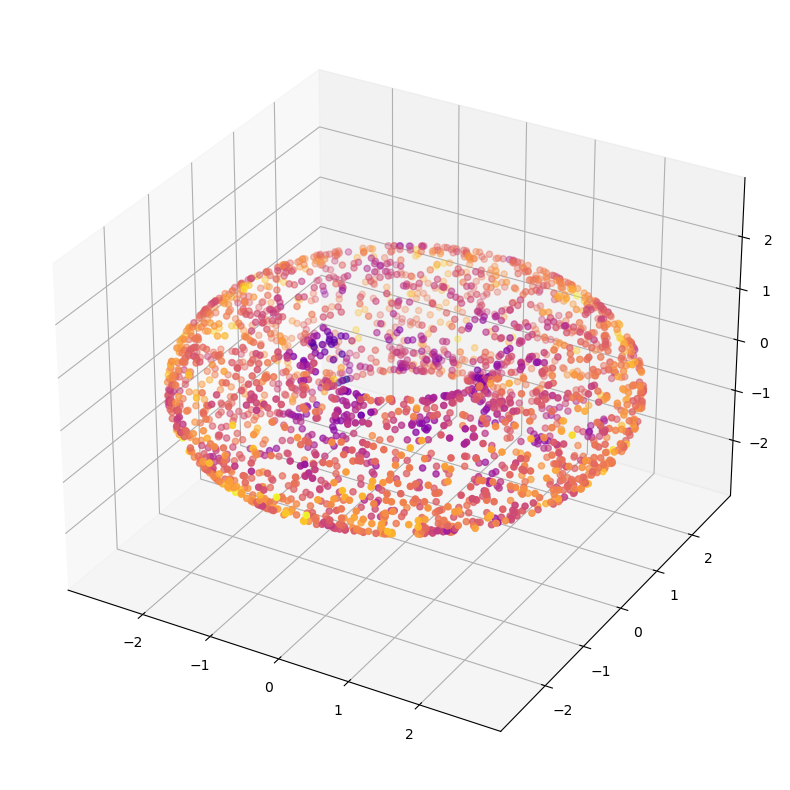

In [32]:
plot_3d(X,P_local_entropy-P_entropy)

In [41]:
X,ks_real = torus(2000,use_guide_points=True)

In [42]:
def rate_of_change_of_entropy(X, k = 10):
    ts = list(range(1,32))
    entropies = np.empty((len(X),len(ts)))
    for idx, t in tqdm(enumerate(ts)):
        entropies[:,idx] = entropy_of_diffusion(X,t, k=k)
    return entropies

In [43]:
es = rate_of_change_of_entropy(X)

0it [00:00, ?it/s]

In [44]:
es

array([[3.8700881 , 4.59352597, 5.00592846, ..., 6.67580144, 6.68937563,
        6.7020355 ],
       [4.13095353, 4.79737451, 5.24013314, ..., 6.79740257, 6.80316676,
        6.80852333],
       [4.00012941, 4.73446181, 5.17250675, ..., 6.71862715, 6.72927574,
        6.73921799],
       ...,
       [4.2884649 , 4.90220725, 5.25416806, ..., 6.71206274, 6.72365019,
        6.73443922],
       [4.29806616, 4.90428819, 5.25345806, ..., 6.72386315, 6.73478558,
        6.74494933],
       [3.96224787, 4.64665951, 5.08717306, ..., 6.74469737, 6.75397596,
        6.76261786]])

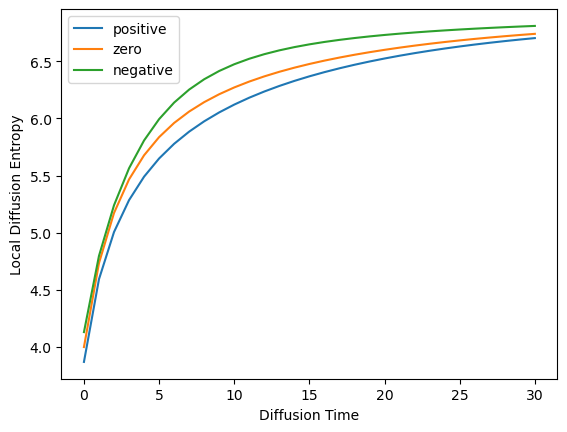

In [45]:
plt.plot(es[0],label='positive')
plt.plot(es[2],label = 'zero')
plt.plot(es[1], label='negative')

plt.xlabel("Diffusion Time")
plt.ylabel("Local Diffusion Entropy")
plt.legend()

It's not clear that the rate of increase of the entropies is different. They do start out a little differently...
No, they all start out flat!

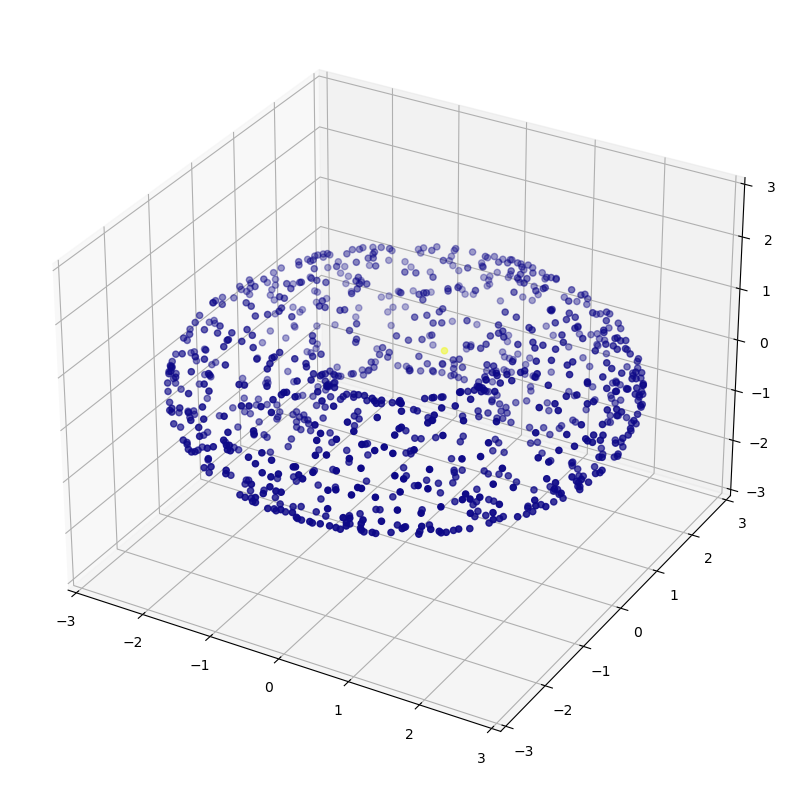

In [ ]:
sig = np.zeros(len(X))
sig[1] = 1
plot_3d(X,sig)